In [22]:
import straxen
from multihist import Hist1d, Histdd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

%run /home/tzpmb0714/ini/initialize_plot.ipynb
#st = straxen.contexts.demo()
st = straxen.contexts.strax_workshop_dali()
straxen.download_test_data()

## Load Backgrond Data

In [13]:
# select all background runs
run_df = st.select_runs()
run_id = tuple(run_df[run_df['mode'] == 'background_triggerless']['name'].values)
# maybe also support array

In [14]:
df = st.get_df(run_id, 'event_info')

Loading 31 runs: 31it [00:01, 15.80it/s]


## Data cleaning

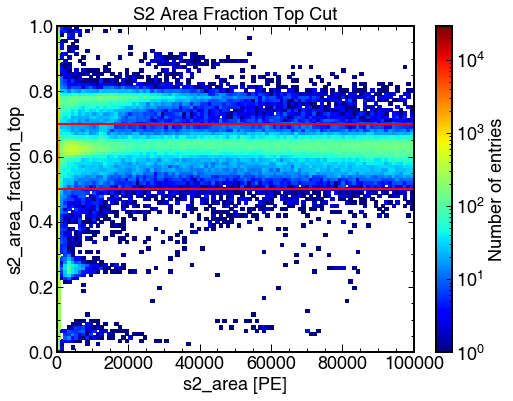

In [38]:
hist2d = Histdd(df.s2_area, df.s2_area_fraction_top, bins=(np.linspace(0, 1e5, 100), np.linspace(0, 1, 100)),
                axis_names=['s2_area [PE]', 's2_area_fraction_top'])
plt.axhline(y=0.7, color='red')
plt.axhline(y=0.5, color='red')
hist2d.plot(norm=LogNorm())
plt.title('S2 Area Fraction Top Cut')
plt.show()

In [35]:
data = df.copy()
data = data[data.eval('0.5 < s2_area_fraction_top < 0.7')]

## Check alpha peak

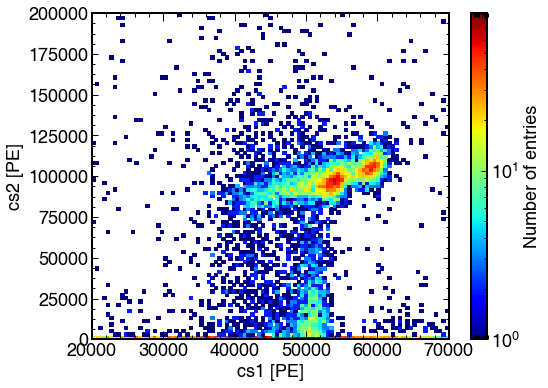

In [37]:
hist2d = Histdd(data.cs1, data.cs2, bins=(np.linspace(2e4, 7e4, 100), np.linspace(0, 2e5, 100)),
                axis_names=['cs1 [PE]', 'cs2 [PE]'])
hist2d.plot(norm=LogNorm())
plt.show()

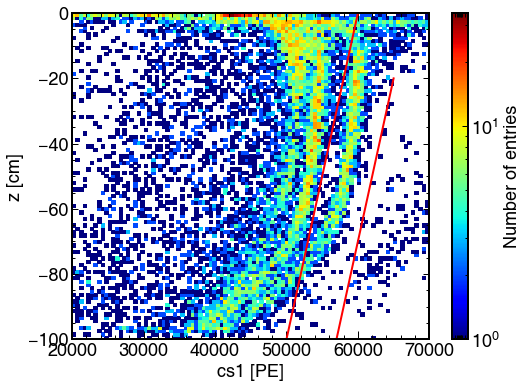

In [71]:
# a rough way to get Po218 population... s1 alpha map takes more time
hist2d = Histdd(df.cs1, df.z, bins=(np.linspace(2e4, 7e4, 100), np.linspace(-100, 0, 100)),
                axis_names=['cs1 [PE]', 'z [cm]'])
hist2d.plot(norm=LogNorm())
def prelim_cut(x, a, b):
    return a*x + b

x = np.linspace(5e4, 6.5e4, 100)
plt.plot(x, prelim_cut(x, 0.01, -600), color='red')
plt.plot(x, prelim_cut(x, 0.01, -670), color='red')
plt.show()

In [72]:
data_po218 = data[(data.z > prelim_cut(data.cs1, 0.01, -670)) & (data.z < prelim_cut(data.cs1, 0.01, -600))]

In [55]:
def multi_gaus(x, a1, a2, a3, mu1, mu2, mu3, sig1, sig2, sig3, const):
    return a1*np.exp(-0.5*(x-mu1)**2/sig1**2) + a2*np.exp(-0.5*(x-mu2)**2/sig2**2)+ a3*np.exp(-0.5*(x-mu3)**2/sig3**2) + const

In [77]:
def elife_fit(x, a, elife, const):
    return a*np.exp(-x/elife) + const

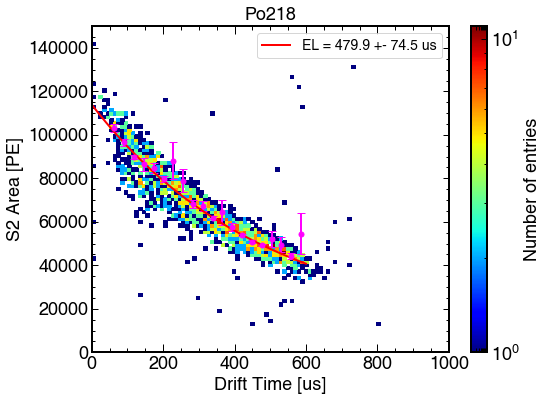

In [102]:
data_po218 = data_po218[data_po218.s2_area > 1e4]
hist2d = Histdd(data_po218.drift_time/1e3, data_po218.s2_area, 
                bins=(np.linspace(0, 1e3, 100), np.linspace(0, 1.5e5, 100)),
                axis_names=['Drift Time [us]', 'S2 Area [PE]'])
hist2d.plot(norm=LogNorm())
plt.title('Po218')

# fit elife
drift_times = np.linspace(50, 600, 21)
drift_min_s, drift_max_s = drift_times[:-1], drift_times[1:]
s2, s2_unc, dt = [], [], []
for drift_min, drift_max in zip(drift_min_s, drift_max_s):
    data_tmp = data_po218[(data_po218.drift_time/1e3 < drift_max) & (data_po218.drift_time/1e3 > drift_min)]
    s2.append(np.average(data_tmp.s2_area))
    s2_unc.append(np.std(data_tmp.s2_area) / np.sqrt(len(data_tmp)))
    dt.append((drift_min + drift_max)/2)
    
plt.errorbar(dt, s2, yerr=s2_unc, fmt='o', color='magenta', ms=5)
popt, pcov = curve_fit(elife_fit, dt, s2, sigma=s2_unc, p0=[1e5, 400, 0])
perr = np.sqrt(np.diag(pcov))
x = np.linspace(0, 600, 100)
plt.plot(x, elife_fit(x, *popt), 'r-', label='EL = %.1f +- %.1f us' %(popt[1], perr[1]))
plt.legend()
plt.show()

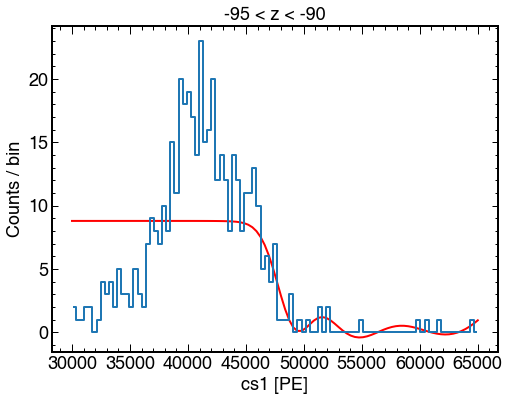

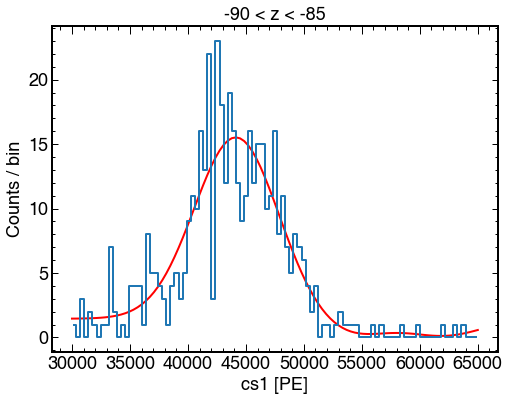

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 2200.

In [59]:
# proof that I tried s1-alpha map..
z_s = np.linspace(-95, -5, 19)
z_max_s, z_min_s = z_s[1:], z_s[:-1]

alpha_map = {'z': [],
             's1': []}

for z_min, z_max in zip(z_min_s, z_max_s):
    data_tmp = data[(data.z < z_max) & (data.z > z_min)]
    hist = Hist1d(data_tmp.cs1, bins=np.linspace(3e4, 6.5e4, 100))
    popt, pcov = curve_fit(multi_gaus, hist.bin_centers, hist.histogram, 
                           p0=[30, 30, 25, 5e4, 5.5e4, 6e4, 3e3, 3e3, 3e3, 0])
    x = np.linspace(3e4, 6.5e4, 100)
    plt.plot(x, multi_gaus(x, *popt), 'r-')
    hist.plot()
    plt.title('%d < z < %d' %(z_min, z_max))
    plt.xlabel('cs1 [PE]')
    plt.ylabel('Counts / bin')

    # save fit value
    s1_po218 = popt[5]
    alpha_map['z'].append((z_min + z_max)/2)
    alpha_map['s1'].append(s1_po218)
    plt.show()